### Import Libraries

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import numpy as np
import quantecon as qe
from _model_individual import FireProblem

### Plotting Preferences

In [2]:
from matplotlib import cm
%matplotlib inline

### Solve for the Value Function

In [3]:
fp = FireProblem(w=40)
v_init = np.array([np.ones((fp.n, 1, fp.t.size))*i for i in range(fp.y.size)]).reshape(fp.n,fp.y.size,fp.t.size)
#v_init = np.ones((fp.n, fp.y.size, fp.t.size))*10
v = qe.compute_fixed_point(fp.bellman_operator, v_init, error_tol=1e-3, print_skip=10, max_iter=1000)

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
10           1.772e+00      8.113e+01         
20           9.992e-01      1.627e+02         
30           5.902e-01      2.456e+02         
40           3.534e-01      3.287e+02         
50           2.133e-01      4.040e+02         
60           1.295e-01      4.794e+02         
70           8.179e-02      5.507e+02         
80           5.183e-02      6.200e+02         
90           3.285e-02      6.970e+02         
100          2.081e-02      7.829e+02         
110          1.319e-02      8.726e+02         
120          8.359e-03      9.595e+02         
130          5.297e-03      1.044e+03         
140          3.357e-03      1.302e+03         
150          2.128e-03      1.378e+03         
160          1.348e-03      1.460e+03         


### Solve for the Optimal Policy

In [4]:
optimal_policy = fp.get_greedy(v)

### Plot the Value Function

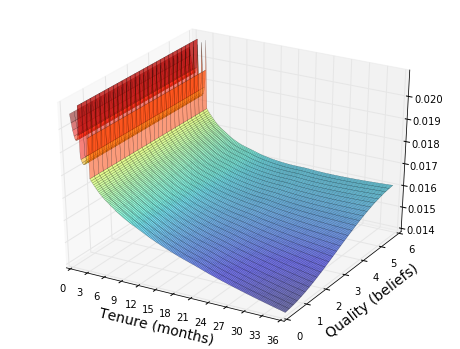

In [5]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
tg, yg = np.meshgrid(fp.t, fp.y)
ax.plot_surface(tg,
                yg,
                v[0,:,:], #for worker 0
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)

ax.set_zlim(np.amin(v[0,:,:]), np.amax(v[0,:,:]))
ax.set_xlabel('Tenure (months)', fontsize=14)
ax.set_ylabel('Quality (beliefs)', fontsize=14)

ax.set_xlim(0,fp.T_max)
labels = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
plt.xticks(np.linspace(0, fp.T_max+1, (fp.T_max+1)/30+1), labels)
plt.show()

### Plot the Optimal Policy

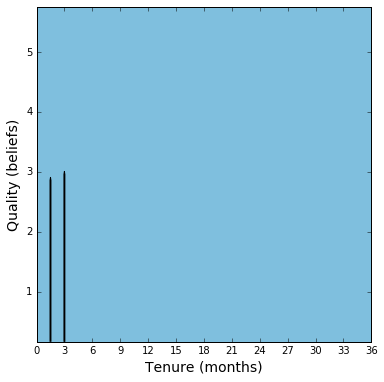

In [6]:
fig, ax = plt.subplots(figsize=(6,6))
tg, yg = np.meshgrid(fp.t, fp.y)

lvls=(-0.5, 0.5)
ax.contourf(tg, yg, optimal_policy[0,:,:], levels=lvls, cmap=cm.winter, alpha=0.5) #for worker 0
ax.contour(tg, yg, optimal_policy[0,:,:], colors='k', levels=lvls, linewidths=1) #for worker 0

ax.set_xlabel('Tenure (months)', fontsize=14)
ax.set_ylabel('Quality (beliefs)', fontsize=14)

ax.set_xlim(0,fp.T_max)
labels = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
plt.xticks(np.linspace(0, fp.T_max+1, (fp.T_max+1)/30+1), labels)
plt.show()

In [1]:
%matplotlib

Using matplotlib backend: Qt4Agg


In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
tg, yg = np.meshgrid(fp.t, fp.y)
ax.plot_surface(tg,
                yg,
                v[0,:,:], #for worker 0
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)

ax.set_zlim(np.amin(v[0,:,:]), np.amax(v[0,:,:]))
ax.set_xlabel('Tenure (months)', fontsize=14)
ax.set_ylabel('Quality (beliefs)', fontsize=14)

ax.set_xlim(0,fp.T_max)
labels = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
plt.xticks(np.linspace(0, fp.T_max+1, (fp.T_max+1)/30+1), labels)
plt.show()

### Checks on VFI Solution

In [ ]:
import scipy.integrate as integrate
from scipy import interp
%matplotlib inline
new_v = fp.bellman_operator(v)

In [ ]:
#REPEAT UNTIL CONVERGENCE
#...code should use v instead of new_v in the v_cols formula 

#Piecewise linear interpolation functions of x: (x,y)=(y-grid-points,value)
#...represents the (converging) value assigned V(y',t+1) at each grid point (y,t)
#...loops necessary due to list comprehension issues with lambda functions
v_cols = np.empty(fp.n*fp.y.size*fp.t.size, dtype=object)
it=0
for k in range(fp.n):
    for i in range(fp.y.size):
        for j in range(fp.t.size):
            v_cols[it] = np.array([(lambda z: (lambda x: interp(x, fp.y, z)))(new_v[k,:,j])])
            it = it+1

#Keep worker
#...E[V(y',t+1)]: integrate value function with density h_grid (include 95% CI in integral bounds)
E0 = np.array([integrate.fixed_quad(lambda x: v_cols[l][0](x)*fp.h_grid[l](x), i-3*j**0.5, i+3*j**0.5)[0] for l, (i, j) in enumerate(zip(fp.mu_grid.flatten(),fp.sigma_grid.flatten()))]).reshape(fp.n,fp.y.size,fp.t.size)
v0 = fp.beta*E0

#Fire worker
#...E[V(y',t+1)]: integrate value function with density h_0 (include 95% CI in integral bounds)
E1 = np.array([integrate.fixed_quad(lambda x: v_cols[l][0](x)*fp.h_0(x), fp.y_0+fp.w/10-3*fp.sig2_0**0.5, fp.y_0+fp.w/10+3*fp.sig2_0**0.5)[0] for l, (i, j) in enumerate(zip(fp.mu_grid.flatten(),fp.sigma_grid.flatten()))]).reshape(fp.n,fp.y.size,fp.t.size)
v1 = -fp.costs + fp.beta*E1

In [ ]:
### v_cols: functions that will be integrated with density h_grid or h_0 [varies with each iteration]
q = 0 #change q from 0 to y.size to look at the increasing mean and same variance
r = 29 #change r from 0 to t.size to look at different tenures
fig, ax = plt.subplots()
x = fp.y
z = v_cols[q*(fp.T_max+1)+r][0](x)
ax.set_ylim(np.amin(v_cols[q*(fp.T_max+1)+r][0](x)), np.amax(v_cols[q*(fp.T_max+1)+r][0](x)))
ax.plot(x, z, 'r-', linewidth=2, alpha=0.6)
ax.set_xlabel('Match Quality (Grid)', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
plt.show()